
# LevoBellmanOptim‑ZO (no backprop)
**Idea:** Hybrid optimization that combines an **analytical** signal (Bellman / TD) with a **reflexive** phase (*levo*, left-handed heuristic) **without using backpropagation**.
It updates with **zero order** (ES/SPSA-like) directly in the parameter space.


In [7]:

# --- Environment and Seed Info ---
import os, random, numpy as np, sys

np.random.seed(0)
random.seed(0)

try:
    import tensorflow as tf, keras
    tf.random.set_seed(0)
    print("TF:", tf.__version__, "| Keras:", keras.__version__)
except Exception as e:
    print("TF/Keras no disponibles:", e)

import torch, sklearn
torch.manual_seed(0)

print("Torch:", torch.__version__, "| Sklearn:", sklearn.__version__)
print("Python:", sys.version)


TF: 2.20.0 | Keras: 3.11.3
Torch: 2.6.0 | Sklearn: 1.6.1
Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


## Synthetic data and utilities

In [8]:

from typing import Tuple
import numpy as np

# Synthetic dataset: states s, actions a, rewards r, next states s'
def make_synth_batch(batch_size=64, d_state=5, n_actions=3, gamma=0.97) -> dict:
    s  = np.random.rand(batch_size, d_state).astype("float32")
    sp = np.random.rand(batch_size, d_state).astype("float32")
    a  = np.random.randint(0, n_actions, size=(batch_size,)).astype("int64")
    r  = (np.random.randn(batch_size) * 0.1).astype("float32")
    done = (np.random.rand(batch_size) < 0.05).astype("float32")
    return {"s": s, "sp": sp, "a": a, "r": r, "done": done, "gamma": gamma, "n_actions": n_actions}


## Keras autoencoder (resonance) and left-handed heuristics

In [9]:

import numpy as np

#AE in Keras to measure (1 - cos) resonance on reconstruction
AE_INPUT_DIM = 5
try:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense

    inp = Input(shape=(AE_INPUT_DIM,), name="ae_inp")
    z   = Dense(3, activation="relu", name="enc")(inp)
    out = Dense(AE_INPUT_DIM, activation="sigmoid", name="dec")(z)
    ae_keras = Model(inp, out)
    ae_keras.compile(optimizer="adam", loss="mse")

    # pre-train with simple noise
    X_pre = np.random.rand(1024, AE_INPUT_DIM).astype("float32")
    ae_keras.fit(X_pre, X_pre, epochs=5, verbose=0)
    print("AE Keras listo ✅")
except Exception as e:
    ae_keras = None
    print("No se pudo crear AE Keras:", e)

from sklearn.metrics.pairwise import cosine_similarity
from typing import Tuple

def levo_izquierda(vec: np.ndarray, ae, orig: np.ndarray, e:int=20, d:float=0.05,
                   lr:float=0.1, cool:float=0.90, bias:float=-0.35) -> Tuple[np.ndarray, float]:
    """
       Left-handed (push-pull) heuristic on the input vector.
       vec: (d,) starting point
       ae: model with .predict(vec[None, :]) -> (1, d)
       orig: (d,) target vector for measuring resonance (cosine with reconstruction)
    """
    rng = np.random.default_rng(0)  # reproducible per call
    best = vec.copy()
    best_cos = -1.0
    mod = vec.copy()
    delta = float(d)

    for _ in range(e):
        phase = 2*np.pi*(mod + bias)       # left-handed turn (negative bias)
        prop = np.clip(
            -mod + rng.uniform(-delta, delta, vec.shape) + 0.1*np.sin(phase),
            0, 1
        )
        rec_prop = ae.predict(prop.reshape(1, -1), verbose=0)
        cos_prop = float(cosine_similarity(orig.reshape(1, -1), rec_prop)[0, 0])

        rec_mod = ae.predict(mod.reshape(1, -1), verbose=0)
        cos_mod = float(cosine_similarity(orig.reshape(1, -1), rec_mod)[0, 0])

        if cos_prop >= cos_mod:   # acceptance not to get worse
            mod = prop
        if cos_prop > best_cos:
            best_cos = cos_prop
            best = prop.copy()

        delta *= max(1e-4, (1 - cos_prop) * lr)
        delta = float(np.clip(delta * cool, 1e-5, 0.25))

    return best, best_cos


AE Keras listo ✅


## Q‑network (PyTorch) and Bellman loss**whitout backward**

In [10]:

import torch, torch.nn as nn

class QNet(nn.Module):
    def __init__(self, d_state=5, n_actions=3, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_state, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)

def bellman_loss_forward(qnet: nn.Module, tgt: nn.Module, batch: dict) -> torch.Tensor:
    """ TD error forward-only (no backward) """
    s  = torch.from_numpy(batch["s"])
    sp = torch.from_numpy(batch["sp"])
    a  = torch.from_numpy(batch["a"])
    r  = torch.from_numpy(batch["r"])
    done = torch.from_numpy(batch["done"])
    gamma = batch["gamma"]

    with torch.no_grad():
        q_sp = tgt(sp).max(dim=1).values
        target = r + (1.0 - done) * gamma * q_sp

    q_sa = qnet(s).gather(1, a.view(-1,1)).squeeze(1)
    td = (target - q_sa)
    return (td * td).mean()


## **LevoBellmanOptim‑ZO** (orden cero; actualización estilo Lion‑sign con weight‑decay desacoplado)

In [11]:

from typing import Callable, List
import torch

def collect_params(model: nn.Module) -> List[torch.Tensor]:
    return [p for p in model.parameters() if p.requires_grad]

def clone_like(params: List[torch.Tensor]) -> List[torch.Tensor]:
    return [torch.zeros_like(p) for p in params]

@torch.no_grad()
def _snapshot(params: List[torch.Tensor]) -> List[torch.Tensor]:
    return [p.detach().clone() for p in params]

@torch.no_grad()
def _assign(params: List[torch.Tensor], src: List[torch.Tensor]):
    for p, s in zip(params, src):
        p.copy_(s)

@torch.no_grad()
def _add_scaled(params: List[torch.Tensor], base: List[torch.Tensor],
                eps: List[torch.Tensor], alpha: float):
    for p, b, e in zip(params, base, eps):
        p.copy_(b + alpha * e)

@torch.no_grad()
def _sign_update(params: List[torch.Tensor], g_hat: List[torch.Tensor], lr: float, wd: float=1e-2):
    for p, g in zip(params, g_hat):
        if wd > 0: p.mul_(1 - lr*wd)     # AdamW-like (decoupled)
        p.add_(-lr * torch.sign(g))      # Lion-like (sign)

def eval_total_loss_forward(qnet: nn.Module, tgt: nn.Module, batch: dict,
                            ae, lam: float,
                            levo_fn: Callable) -> torch.Tensor:
    # Bellman forward
    Lb = bellman_loss_forward(qnet, tgt, batch)

    # Levo forward (inputs [0,1])
    x = batch["s"]
    orig = batch["sp"]
    cos_list = []
    if ae is not None:
        for i in range(min(16, x.shape[0])):
            vec = x[i]; tar = orig[i]
            _, cosv = levo_fn(vec, ae, tar)
            cos_list.append(cosv)
    Ll = torch.tensor(float(np.mean([1.0 - c for c in cos_list]))) if len(cos_list)>0 else torch.tensor(0.0)
    return Lb + lam * Ll

def levobellman_zo_step(qnet: nn.Module, tgt: nn.Module, batch: dict,
                        ae, lam: float=0.1, sigma: float=0.02, N: int=8, lr: float=1e-2, wd: float=1e-2,
                        levo_fn=levo_izquierda):
    params = collect_params(qnet)
    base = _snapshot(params)
    g_hat = clone_like(params)

    for _ in range(N):
        eps = [torch.randn_like(p) for p in params]

        # theta+
        _add_scaled(params, base, eps,  sigma)
        Lp = eval_total_loss_forward(qnet, tgt, batch, ae, lam, levo_fn)

        # theta-
        _add_scaled(params, base, eps, -sigma)
        Lm = eval_total_loss_forward(qnet, tgt, batch, ae, lam, levo_fn)

        coeff = (Lp - Lm) / (2.0 * sigma)
        for g, e in zip(g_hat, eps):
            g.add_(coeff * e)

    # Average
    for g in g_hat:
        g.div_(float(N))

    # restauration and update
    _assign(params, base)
    _sign_update(params, g_hat, lr=lr, wd=wd)


## Demo rápida (10 iteraciones)

In [12]:

qnet = QNet(d_state=5, n_actions=3)
target_q = QNet(d_state=5, n_actions=3)
target_q.load_state_dict(qnet.state_dict())

history = {"LB": [], "LL": [], "Ltot": []}

for t in range(10):
    batch = make_synth_batch(batch_size=64, d_state=5, n_actions=3, gamma=0.97)

    # Metrics before the step ZO
    Lb0 = float(bellman_loss_forward(qnet, target_q, batch))

    # Estimation Resonance
    x = batch["s"]; orig = batch["sp"]
    cos_list = []
    if ae_keras is not None:
        for i in range(min(8, x.shape[0])):
            _, cosv = levo_izquierda(x[i], ae_keras, orig[i])
            cos_list.append(cosv)
    Ll0 = float(np.mean([1.0 - c for c in cos_list])) if cos_list else 0.0
    Ltot0 = Lb0 + 0.1*Ll0

    history["LB"].append(Lb0); history["LL"].append(Ll0); history["Ltot"].append(Ltot0)

    # Step ZO
    levobellman_zo_step(qnet, target_q, batch, ae=ae_keras, lam=0.1, sigma=0.02, N=8, lr=1e-2, wd=1e-2)

    # Soft update target
    tau = 0.05
    with torch.no_grad():
        for p_tgt, p in zip(target_q.parameters(), qnet.parameters()):
            p_tgt.copy_( (1-tau)*p_tgt + tau*p )

print("Done. Iterations:", len(history["LB"]))


Listo. Iteraciones: 10


## Graphics

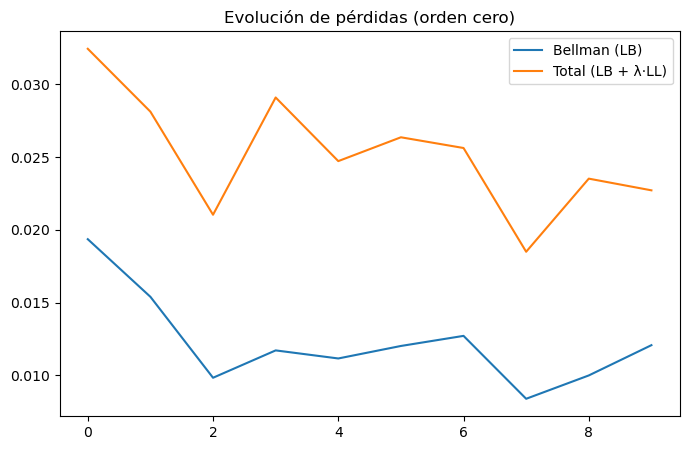

In [13]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history["LB"], label="Bellman (LB)")
plt.plot(history["Ltot"], label="Total (LB + λ·LL)")
plt.legend(); plt.title("Evolution of losses (zero order); plt.show()



### Notes
- Backward() is not used: updates are estimated in zeroth order (perturbations).
- The levo term is calculated with an EA in Keras (TF/Keras + Torch coexistence), measuring resonance (1 − cos).
- The update step is Lion-like (sign-based) with decoupled weight decay (AdamW-like).
- You can enable Lookahead/Weight EMA as an additional tempering step if desired.
- Useful hyperparameters: sigma (perturbation scale), N (directions), lr, lam (levo weight).
